## Применение логистической регрессии к задаче классификации текстов

В этом ноутбуке мы попробуем обучить простую линейную модель - логистическую регрессии на наших текстовых данных для решения задачи классификации

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import scipy as sp
from scipy.sparse import csr_matrix
import random
from sklearn.model_selection import GridSearchCV


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/lenta-news/lenta_news_with_lemmas2.csv
/kaggle/input/lentanewsmodel/train_200k_texts.csv
/kaggle/input/lentanewsmodel/ytrain_200k_texts.csv
/kaggle/input/lentanewsmodel/test_50k_texts.csv
/kaggle/input/lentanewsmodel/ytest_50k_texts.csv


In [19]:
df = pd.read_csv('/kaggle/input/lenta-news/lenta_news_with_lemmas2.csv')

Перед тем как обучать модели необходимо преобразовать их в понятный для модели вид - векторное пространство. Делать это будем при помощи TF-IDF - модель, которая показывает отношение частоты употребления слова в отдельном тексте к частоте употребления слова во всех документах. В данной модели можно задавать параметр ngram_range, который будет строить уни-, би-, триграммы (и так далее), учитывая не одно слово в отдельности, а сразу несколько.

Ради интереса посмотрим какие уни-, би- и триграммы популярны на всем датасете

In [11]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.split(' ')]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

100%|██████████| 1153088/1153088 [01:51<00:00, 10328.98it/s]


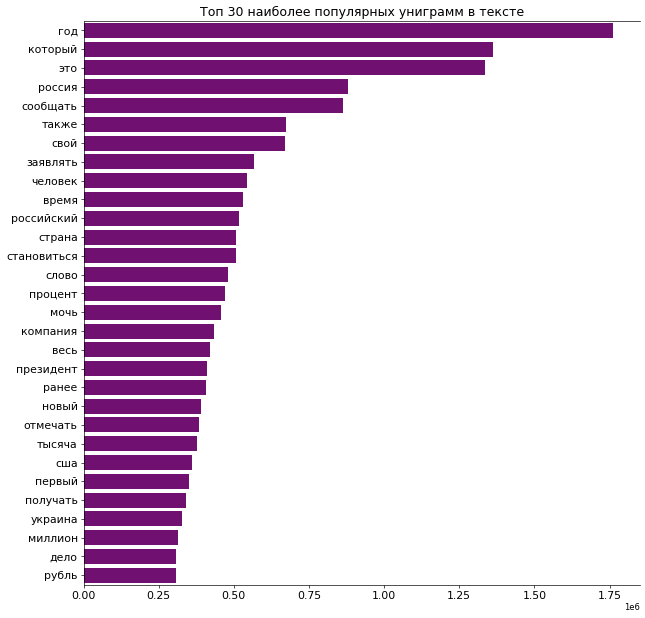

In [13]:
unigrams = defaultdict(int)
for row in tqdm(df['text']):
    for word in generate_ngrams(row, 1):
        unigrams[word] += 1
        
df_unigrams = pd.DataFrame(sorted(unigrams.items(), key=lambda x: x[1])[::-1])

N = 30
unigrams_less_100 = df_unigrams[:N]

fig, axes = plt.subplots(ncols=1, figsize=(10, N//3), dpi=60)
plt.tight_layout()

sns.barplot(y=unigrams_less_100[0], x=unigrams_less_100[1], ax=axes, color='purple')

axes.spines['right'].set_visible(False)
axes.set_xlabel('')
axes.set_ylabel('')
axes.tick_params(axis='x', labelsize=13)
axes.tick_params(axis='y', labelsize=13)

axes.set_title(f'Топ {N} наиболее популярных униграмм в тексте', fontsize=15)

plt.savefig('unigrams.png')
plt.show()

100%|██████████| 1153088/1153088 [03:25<00:00, 5600.59it/s]


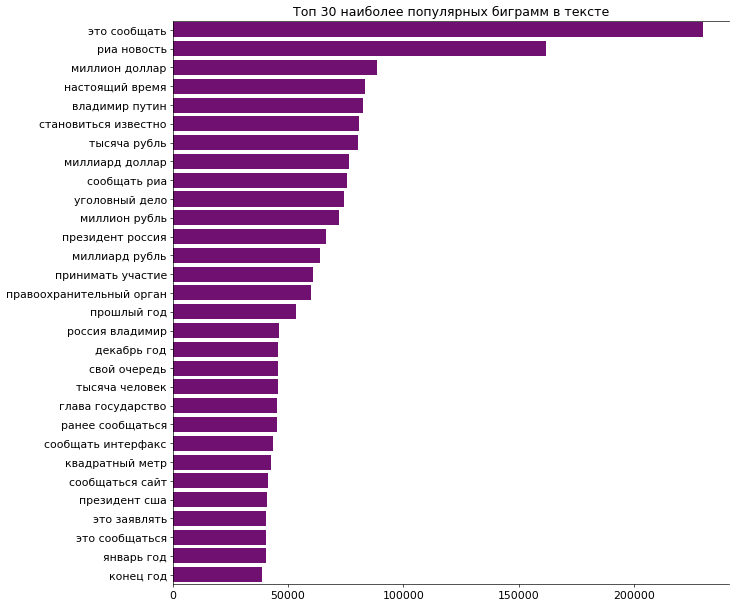

In [19]:
bigrams = defaultdict(int)
for row in tqdm(df['text']):
    for word in generate_ngrams(row, 2):
        bigrams[word] += 1
        
df_bigrams = pd.DataFrame(sorted(bigrams.items(), key=lambda x: x[1])[::-1])

N = 30
bigrams_less_100 = df_bigrams[:N]

fig, axes = plt.subplots(ncols=1, figsize=(10, N//3), dpi=60)
plt.tight_layout()

sns.barplot(y=bigrams_less_100[0], x=bigrams_less_100[1], ax=axes, color='purple')

axes.spines['right'].set_visible(False)
axes.set_xlabel('')
axes.set_ylabel('')
axes.tick_params(axis='x', labelsize=13)
axes.tick_params(axis='y', labelsize=13)

axes.set_title(f'Топ {N} наиболее популярных биграмм в тексте', fontsize=15)

fig.savefig('bigrams.png', bbox_inches='tight')
plt.show()

In [12]:
text_list = df['text']

del df

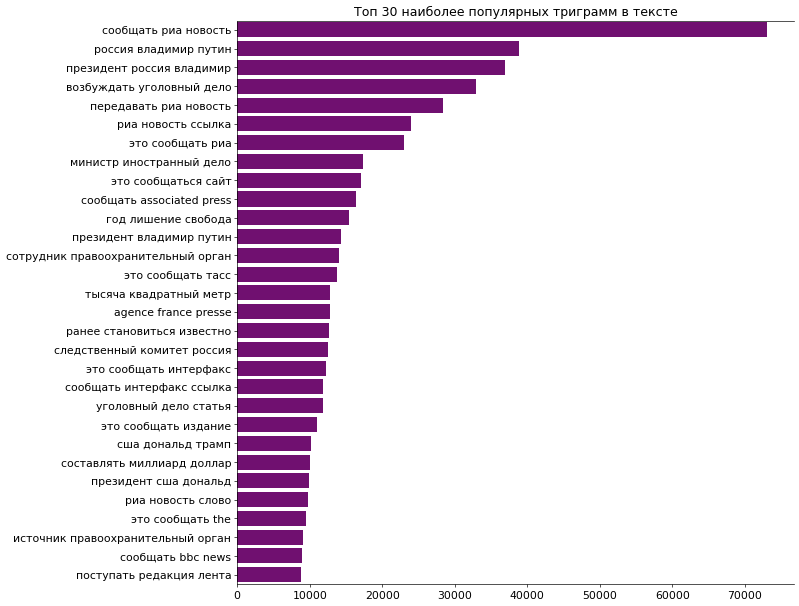

In [16]:
threegrams = defaultdict(int)
for row in tqdm(text_list[:1_100_000]):
    for word in generate_ngrams(row, 3):
        threegrams[word] += 1
        
df_threegrams = pd.DataFrame(sorted(threegrams.items(), key=lambda x: x[1])[::-1])

N = 30
threegrams_less_100 = df_threegrams[:N]
del threegrams

fig, axes = plt.subplots(ncols=1, figsize=(10, N//3), dpi=60)
plt.tight_layout()

sns.barplot(y=threegrams_less_100[0], x=threegrams_less_100[1], ax=axes, color='purple')

axes.spines['right'].set_visible(False)
axes.set_xlabel('')
axes.set_ylabel('')
axes.tick_params(axis='x', labelsize=13)
axes.tick_params(axis='y', labelsize=13)

axes.set_title(f'Топ {N} наиболее популярных триграмм в тексте', fontsize=15)

fig.savefig('threegrams.png', bbox_inches='tight')
plt.show()

Получилось весьма интересно, по этим графикам можно в целом сделать выводы по наиболее популярным темам в новостях (политика, экономика)


Наш датасет довольно большой, поэтому мы решили выделить его часть для тестирования моделей. Поскольку наши данные привязаны ко времени, можно было бы взять отложенную выборку на каком-то конкретном промежутке времени. Однако поскольку сейчас мы решаем задачу классификации, нам важнее, чтобы в нашей небольшой выборке все классы были представлены в таком же соотношении, как и на всем датасете. Для начала следует проверить все ли классы представлены в каждом году

In [34]:
for i in df['topic'].unique():
    print(i)
    if df[df['topic'] == i]['year'].nunique() != 24:
        print(df[df['topic'] == i]['year'].unique())

Россия
Мир
Экономика
Интернет и СМИ
Спорт
[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020 2021 2022]
Культура
[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020 2021 2022]
Из жизни
[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020 2021 2022]
Силовые структуры
[2002 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2020 2021 2022]
Наука и техника
[2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2020 2021 2022]
Бывший СССР
[2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2020 2021 2022]
Дом
[2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019
 2020 2021]
Путешествия
[2014 2015 2016 2017 2018 2019 2020 2021 2022]
Библиотека
[2014 2015]
Ценности
[2014 2015 2016 2017 2018 2019 2020 2021 2022]
Легпром
[2014 2015 2016]
Б

В каждом году представлены только классы Россия, Мир, Экономика, Интернет и СМИ. Остальные присутствуют не на всем промежутке времени, а некоторые и вовсе только в одном году. Поэтому наша выборка не будет привязана к конкретному времени

In [2]:
# тестовый датасет был сделан в другом ноутбуке
df_train = pd.read_csv('/kaggle/input/lentanewsmodel/train_200k_texts.csv')
df_train.shape

(207556, 15)

In [3]:
df_train = df_train[~(df_train['topic'].isin(['Библиотека', 'Оружие']))]
df_train.reset_index(drop=True, inplace=True)

dict_topic = dict(zip(df_train.topic, df_train.topic_le))
dict_topic = {k: v for k, v in sorted(dict_topic.items(), key=lambda item: item[1])}

In [4]:
df_train.head()

,Unnamed: 0,date,url,topic,tags,text_str,topic_le,title_lemmas,year,month,day,date_enc,seanos,day_of_week,dummy_weekday
0,337202,2010-07-12,https://lenta.ru/news/2010/07/12/explosion/,Россия,Все,запад москва квартира этажный дом происходить ...,20,дом запад москва происходить взрыв газ,2010,7,12,3966,3,0,1
1,460023,2013-03-29,https://lenta.ru/news/2013/03/29/samogon/,Бывший СССР,NaN,украина предлагать вводить уголовный ответстве...,3,украинский самогонщик пригрозить уголовный отв...,2013,3,29,4958,2,4,1
2,340676,2010-08-09,https://lenta.ru/news/2010/08/09/aliev/,Интернет и СМИ,Все,улица москва близкий время появляться социальн...,7,андрей тихонов сергей игнашевич рекламировать ...,2010,8,9,3993,3,0,1
3,88483,2004-02-28,https://lenta.ru/news/2004/02/28/chita/,Россия,Все,ход расследование взрыв читинский кафе онон за...,20,чита задерживать предполагать виновник взрыв кафе,2004,2,28,1642,1,5,0
4,939735,2021-06-18,https://lenta.ru/news/2021/06/18/iron/,Ценности,Явления,эксперт раскрывать альтернативный способ погла...,25,эксперт раскрывать способ погладить одежда утюг,2021,6,18,7957,3,4,1


Попробуем обучить модель на уни- и биграммах

In [28]:
%%time

vec = TfidfVectorizer(ngram_range=(1, 2), max_df=0.8, min_df=0.0001, max_features=100_000)
bow = vec.fit_transform(df_train['text_str'])

CPU times: user 2min 24s, sys: 6.3 s, total: 2min 31s
Wall time: 2min 31s


In [29]:
bow.shape

(207543, 100000)

In [30]:
%%time

clf = LogisticRegression(random_state=42, max_iter=500, warm_start=True, n_jobs=4)

y_train = df_train['topic_le']

clf.fit(bow, y_train)

CPU times: user 246 ms, sys: 470 ms, total: 716 ms
Wall time: 16min 5s


LogisticRegression(max_iter=500, n_jobs=4, random_state=42, warm_start=True)

In [31]:
df_test = pd.read_csv('/kaggle/input/lentanewsmodel/test_50k_texts.csv')
df_test = df_test[~(df_test['topic'].isin(['Библиотека', 'Оружие']))]
df_test.reset_index(drop=True, inplace=True)

In [32]:
bow_test = vec.transform(df_test['text_str'])

In [33]:
y_test_pred = clf.predict(bow_test)

In [21]:
f1_score(df_test['topic_le'], y_test_pred, average='micro')

0.8277282582510237

In [22]:
print(classification_report(df_test['topic_le'], y_test_pred, target_names=dict_topic))

                   precision    recall  f1-score   support

   69-я параллель       0.82      0.37      0.51       121
           Бизнес       0.74      0.11      0.19       268
      Бывший СССР       0.83      0.86      0.85      3376
              Дом       0.84      0.74      0.79       797
    Забота о себе       0.72      0.54      0.62       114
         Из жизни       0.73      0.68      0.71      1613
   Интернет и СМИ       0.80      0.72      0.76      2333
             Крым       0.50      0.04      0.08        24
    Культпросвет        0.00      0.00      0.00        12
         Культура       0.87      0.88      0.87      2584
          Легпром       0.00      0.00      0.00         4
              Мир       0.81      0.86      0.83      7048
       Моя страна       0.85      0.56      0.68       221
  Наука и техника       0.84      0.86      0.85      2722
       Нацпроекты       0.96      0.86      0.91       170
      Путешествия       0.86      0.79      0.82       

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


В целом уже получилось довольно хорошее качество, однако маленькие классы не предсказываются (Культпросвет и Легпром)

Посмотрим какой вклад внесли слова в качество предсказания

In [34]:
# !pip install eli5
import eli5

eli5.show_weights(estimator=clf,
                  feature_names= list(vec.get_feature_names()),
                  target_names=list(dict_topic.keys()),
                  top=(30, 5))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Следует заметить, что биграмм в топ30 признаках очень мало, поэтому попробуем убрать их и обучиться только на униграммах

In [7]:
%%time

vec = TfidfVectorizer(ngram_range=(1, 1), max_df=0.8, min_df=0.0001)
bow = vec.fit_transform(df_train['text_str'])

CPU times: user 28.3 s, sys: 640 ms, total: 28.9 s
Wall time: 29 s


In [8]:
bow.shape

(207543, 34198)

Также добавим еще 2 признака: год публикации статьи и сезон, оба параметра закодируем при помощи OneHotEncoding

In [9]:
one_hot_enc = OneHotEncoder(drop='first', handle_unknown='ignore')

arr_enc = one_hot_enc.fit_transform(df_train[['seanos', 'year']])

X = sp.sparse.hstack((bow, arr_enc))
X.shape

(207543, 34224)

In [10]:
%%time

clf = LogisticRegression(random_state=42, max_iter=500, warm_start=True, solver='sag', n_jobs=4)

y_train = df_train['topic_le']

X = csr_matrix(X)

clf.fit(X, y_train)

CPU times: user 7min 53s, sys: 190 ms, total: 7min 53s
Wall time: 7min 53s


LogisticRegression(max_iter=500, n_jobs=4, random_state=42, solver='sag',
                   warm_start=True)

In [10]:
bow_test = vec.transform(df_test['text_str'])

dummies = one_hot_enc.fit_transform(df_test[['seanos', 'year']])
X_test = sp.sparse.hstack((bow_test, dummies))
X_test.shape

(41510, 34224)

In [16]:
y_test_pred = clf.predict(X_test)
f1_score(df_test['topic_le'], y_test_pred, average='micro')

0.839123102866779

In [17]:
print(classification_report(df_test['topic_le'], y_test_pred, target_names=dict_topic))

                   precision    recall  f1-score   support

   69-я параллель       0.86      0.45      0.59       121
           Бизнес       0.72      0.53      0.61       268
      Бывший СССР       0.85      0.87      0.86      3376
              Дом       0.88      0.78      0.83       797
    Забота о себе       0.79      0.84      0.82       114
         Из жизни       0.74      0.70      0.72      1613
   Интернет и СМИ       0.79      0.72      0.76      2333
             Крым       0.75      0.25      0.38        24
    Культпросвет        0.00      0.00      0.00        12
         Культура       0.87      0.89      0.88      2584
          Легпром       0.00      0.00      0.00         4
              Мир       0.82      0.86      0.84      7048
       Моя страна       0.86      0.76      0.81       221
  Наука и техника       0.88      0.87      0.87      2722
       Нацпроекты       0.96      0.89      0.93       170
      Путешествия       0.86      0.84      0.85       

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Качество модели стало лучше, попробуем сделать подбор параметров

In [29]:
parameters = {'solver': ['sag'], 'C':[0.3, 0.5, 0.7, 1.5, 2]}
lgr = LogisticRegression(random_state=42, max_iter=500, warm_start=True, n_jobs=-1)
gsc = GridSearchCV(lgr, parameters, verbose=3, cv=5, scoring='f1_micro')
gsc.fit(X, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END .................C=0.3, solver=sag;, score=0.818 total time= 3.3min
[CV 2/5] END .................C=0.3, solver=sag;, score=0.821 total time= 3.5min
[CV 3/5] END .................C=0.3, solver=sag;, score=0.820 total time= 3.1min
[CV 4/5] END .................C=0.3, solver=sag;, score=0.822 total time= 3.1min
[CV 5/5] END .................C=0.3, solver=sag;, score=0.825 total time= 3.1min
[CV 1/5] END .................C=0.5, solver=sag;, score=0.827 total time= 4.2min
[CV 2/5] END .................C=0.5, solver=sag;, score=0.830 total time= 4.6min
[CV 3/5] END .................C=0.5, solver=sag;, score=0.829 total time= 4.2min
[CV 4/5] END .................C=0.5, solver=sag;, score=0.831 total time= 4.3min
[CV 5/5] END .................C=0.5, solver=sag;, score=0.831 total time= 4.2min
[CV 1/5] END .................C=0.7, solver=sag;, score=0.831 total time= 5.1min
[CV 2/5] END .................C=0.7, solver=sag;,

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=500, n_jobs=-1,
                                          random_state=42, warm_start=True),
             param_grid={'C': [0.3, 0.5, 0.7, 1.5, 2], 'solver': ['sag']},
             scoring='f1_micro', verbose=3)

In [13]:
%%time

clf = LogisticRegression(random_state=42, max_iter=500, warm_start=True, solver='sag', C=2, n_jobs=-1)
y_train = df_train['topic_le']

X = csr_matrix(X)

clf.fit(X, y_train)

CPU times: user 18min 22s, sys: 350 ms, total: 18min 23s
Wall time: 9min 22s


LogisticRegression(C=2, max_iter=500, n_jobs=-1, random_state=42, solver='sag',
                   warm_start=True)

In [14]:
y_test_pred = clf.predict(X_test)
f1_score(df_test['topic_le'], y_test_pred, average='micro')

0.8433630450493856

In [15]:
print(classification_report(df_test['topic_le'], y_test_pred, target_names=dict_topic))

                   precision    recall  f1-score   support

   69-я параллель       0.88      0.54      0.67       121
           Бизнес       0.72      0.56      0.63       268
      Бывший СССР       0.85      0.87      0.86      3376
              Дом       0.88      0.80      0.84       797
    Забота о себе       0.81      0.83      0.82       114
         Из жизни       0.74      0.71      0.72      1613
   Интернет и СМИ       0.79      0.73      0.76      2333
             Крым       0.75      0.38      0.50        24
    Культпросвет        0.00      0.00      0.00        12
         Культура       0.88      0.89      0.88      2584
          Легпром       0.00      0.00      0.00         4
              Мир       0.82      0.85      0.84      7048
       Моя страна       0.87      0.77      0.82       221
  Наука и техника       0.88      0.87      0.88      2722
       Нацпроекты       0.96      0.91      0.93       170
      Путешествия       0.87      0.85      0.86       

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Снова удалось улучшить качество при параметре С=2, однако мы видим, что время обучения также возрастает с увеличением гиперпараметра. Попробуем протестировать С=4

In [14]:
%%time

clf = LogisticRegression(random_state=42, max_iter=500, warm_start=True, solver='sag', C=4, n_jobs=-1)
y_train = df_train['topic_le']
X = csr_matrix(X)

clf.fit(X, y_train)

CPU times: user 19min 7s, sys: 369 ms, total: 19min 7s
Wall time: 19min 6s


LogisticRegression(C=4, max_iter=500, n_jobs=-1, random_state=42, solver='sag',
                   warm_start=True)

In [15]:
y_test_pred = clf.predict(X_test)
f1_score(df_test['topic_le'], y_test_pred, average='micro')

0.8442303059503734

In [16]:
print(classification_report(df_test['topic_le'], y_test_pred, target_names=dict_topic))

                   precision    recall  f1-score   support

   69-я параллель       0.86      0.57      0.69       121
           Бизнес       0.73      0.57      0.64       268
      Бывший СССР       0.85      0.87      0.86      3376
              Дом       0.88      0.80      0.84       797
    Забота о себе       0.84      0.84      0.84       114
         Из жизни       0.74      0.72      0.73      1613
   Интернет и СМИ       0.79      0.74      0.77      2333
             Крым       0.75      0.38      0.50        24
    Культпросвет        0.00      0.00      0.00        12
         Культура       0.88      0.89      0.88      2584
          Легпром       0.00      0.00      0.00         4
              Мир       0.82      0.85      0.84      7048
       Моя страна       0.88      0.79      0.84       221
  Наука и техника       0.88      0.87      0.88      2722
       Нацпроекты       0.96      0.92      0.94       170
      Путешествия       0.87      0.86      0.86       

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Качество удалось поднять, однако время обучения выросло в 2 раза и улучшение метрики получилось не очень большое (0.001). В целом остановимся на этой модели и посмотрим влияние признаков

In [24]:
list_name = list(vec.get_feature_names()) + list(one_hot_enc.get_feature_names_out())
len(list_name)

34224

In [27]:
import eli5

eli5.show_weights(estimator=clf,
                  feature_names=list_name,
                  target_names=list(dict_topic.keys()),
                  top=(30, 5))

Видно, что в некоторых классах большое значение имел конкретный год. Например, в классе Моя Страна имели высокое влияние 2020 и 2021 год, что вполне логично, тк этот класс присутствовал только в этих годах

В целом, некоторые классы предсказываются очень хорошо, благодаря ключевым словам. Например, категория Спорт имеет очень высокую точность и полноту, тк в ней присутствует специальная лексика. Другие предсказываются хуже, тк либо очень мало наблюдений, либо мало специальной лексики и много шума (Бизнес, Россия)